# Day 16

## part 1

- Start on `S` facing east and end on `E`
- moving adds 1 point
- rotating 90 degrees adds 1000 points
- lowest score wins

In [16]:
from dataclasses import dataclass
import logging

from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np

from advent_of_code_utils.advent_of_code_utils import (
    parse_from_file, ParseConfig as PC, markdown, plot_str_grid, Point2 as P,
    plot_grid
)

log = logging.getLogger('day 16')
logging.basicConfig(level=logging.INFO)

INFO:advent_of_code_utils.py:141 items loaded from "day_16.txt"
INFO:advent_of_code_utils.py:converted 141x141 to ints


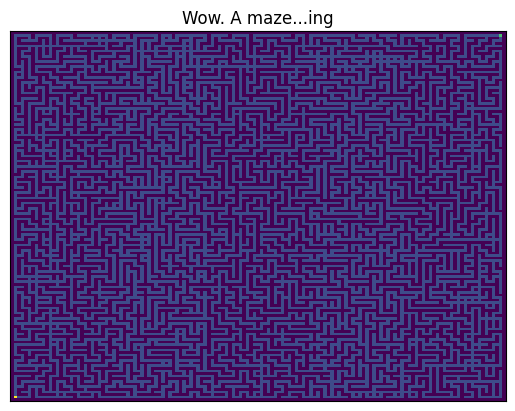

In [2]:
parser = PC('\n', PC('', str))
grid = parse_from_file('day_16.txt', parser)

fig, ax = plt.subplots()
ax.set_title('Wow. A maze...ing')
plot_str_grid(grid, ax)

In [3]:
def get_start_end(grid: list[list[str]]) -> tuple[P]:
    """returns the start and end points"""
    start, end = None, None
    for l, line in enumerate(grid):
        for c, char in enumerate(line):
            if char == 'S':
                start = P(l, c)
            elif char == 'E':
                end = P(l, c)
        if all((p is not None for p in (start, end))):
            log.info(f'{start=}, {end=}')
            return start, end
    else:
        raise ValueError(f'couldn\'t find start/end: {start=}, {end=}')

start, end = get_start_end(grid)

INFO:day 16:start=(139, 1), end=(1, 139)


In [4]:
@dataclass
class Dest:
    point: P
    facing: str
    cost: int

@dataclass
class Node:
    links: list[Dest]
    visited: bool = False
    score: int = None

    def __hash__(self) -> int:
        return hash((self.p, self.f))
    
    def __eq__(self, other: 'Node') -> bool:
        return all((self.p == other.p, self.f == other.f))

offsets = {
    'N': P(-1, 0),
    'E': P(0, 1),
    'S': P(1, 0),
    'W': P(0, -1),
}

cw = {'N': 'E', 'E': 'S', 'S': 'W', 'W': 'N'}
ccw = {value: key for key, value in cw.items()}

# ok next we're gonna need a graph
def get_graph(grid: list[list[str]]) -> list[list[Node | None]]:
    """returns a grid of movement possiblities / None if N/A"""
    # first find all possible nodes - i.e. all intersection points
    graph = [[None]*len(line) for line in grid]
    for l, line in enumerate(grid):
        for c, char in enumerate(line):
            # skip walls
            if char == '#':
                continue
            # find all neighbours
            point = P(l, c)
            neighbours = ''
            for adj, facing in zip(point.adjacent(), offsets):
                if grid[adj.l][adj.c] != '#':
                    neighbours += facing
            # any spaces with only a straight line available should be skipped
            if neighbours in ['EW', 'NS']:
                continue
            # else we have a node - add all possible directions to face
            graph[l][c] = {}
            for facing in offsets:
                links = \
                    [Dest(point, turn[facing], 1000) for turn in (cw, ccw)]
                graph[l][c].update({facing: Node(links)})

    log.info('created grid graph')

    # next find where each node goes and for how much
    for l, line in enumerate(graph):
        for c, directions in enumerate(line):
            if directions is None:
                continue
            tile = P(l, c)
            for direction, node in directions.items():
                # next find where facing that way will go
                point = tile + offsets[direction]
                steps = 1
                while graph[point.l][point.c] is None:
                    if grid[point.l][point.c] == '#':
                        point = None
                        break
                    point += offsets[direction]
                    steps += 1
                if point is not None:
                    node.links.append(Dest(point, direction, steps))
    log.info(f'grid graph links populated')
    return graph

graph = get_graph(grid)


INFO:day 16:created grid graph
INFO:day 16:grid graph links populated


In [5]:
def get_next_node(graph: dict[Node: list[Dest]]) -> Node | None:
    """returns the unvisited node with the lowest score or None if done"""
    lowest_node = None
    for l, line in enumerate(graph):
        for c, nodes in enumerate(line):
            if nodes is None:
                continue
            for node in nodes.values():
                # skip visited
                if node.visited:
                    continue
                # skip nodes that are not visitable yet
                if node.score is None:
                    continue
                if lowest_node is None:
                    lowest_node = node
                elif node.score < lowest_node.score:
                    lowest_node = node
    return lowest_node

def update_scores(graph: dict[Node: list[Dest]], start: P, end: P) -> None:
    """updates the scores navigating from start to end"""
    graph[start.l][start.c]['E'].score = 0
    while True:
        # find an unvisited node with the least score
        node = get_next_node(graph)
        print(f'{node.score=}', end='\r')
        if node is None:
            log.error('tested all reachable node without getting to the end!')
            return

        for dest in node.links:
            dest_node = graph[dest.point.l][dest.point.c][dest.facing]
            if dest_node.visited:
                continue
            new_score = node.score + dest.cost
            if dest_node.score is None:
                dest_node.score = new_score
            elif new_score < dest_node.score:
                dest_node.score = new_score
            # else the destination was closer than via this node

            # if we did get to the end, break!
            if dest.point == end:
                log.info('Reached the end!')
                return

        node.visited = True

update_scores(graph, start, end)

INFO:day 16:Reached the end!


In [6]:
end_nodes = graph[end.l][end.c].values()
min_score = min((node.score for node in end_nodes if node.score is not None))

markdown(
    f'The minimum score for the maze is {min_score}'
)

The minimum score for the maze is 106512

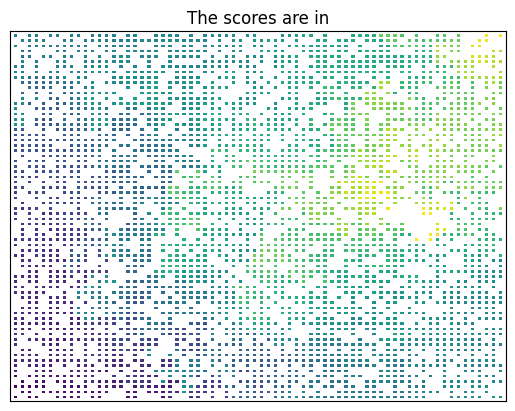

In [20]:
def plot_graph(graph: list[list[dict[Node]]], ax: plt.Axes) -> None:
    temp = []
    for line in graph:
        temp.append([])
        for nodes in line:
            if nodes is None:
                temp[-1].append(np.nan)
                continue
            scores = [
                node.score for node in nodes.values()
                if node.score is not None
            ]
            if len(scores) == 0:
                temp[-1].append(np.nan)
            else:
                temp[-1].append(min(scores))

    plot_grid(temp, ax)


fig, ax = plt.subplots()
ax.set_title('The scores are in')
plot_graph(graph, ax)